# Курсовой проект Гладышева В.В.

## ML задача - определение дефолтов по кредитам

In [1]:
# pip install xgboost

In [2]:
# pip install dill

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss

from typing import List

import dill

# from scipy.stats import shapiro
# from scipy.stats import probplot
# from scipy.stats import ttest_ind, mannwhitneyu
# from scipy.stats import chi2_contingency
# from statsmodels.stats.weightstats import zconfint

# import xgboost as xgb

# from sklearn.model_selection import GridSearchCV

## Загрузка и подготовка данных

In [4]:
datadir = "./data/"
modelsdir = "./models/"
data = pd.read_csv(datadir + "pds_project_train.csv")
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
data['Id'] = np.arange(0, len(data))

In [7]:
def print_categorical(data) -> List:
    for cat_colname in data.columns:
        if len(data[cat_colname].unique()) < 20:
            print(str(cat_colname) + '\n\n' + str(data[cat_colname].unique()) + '\n\n')
            print(data.groupby(cat_colname)[cat_colname].count())
            print('*' * 100 + '\n')

In [8]:
print_categorical(data)

Home Ownership

['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']


Home Ownership
Have Mortgage      12
Home Mortgage    3637
Own Home          647
Rent             3204
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']


Years in current job
1 year        504
10+ years    2332
2 years       705
3 years       620
4 years       469
5 years       516
6 years       426
7 years       396
8 years       339
9 years       259
< 1 year      563
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

[0. 3. 1. 2. 4. 6. 5. 7.]


Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
**********

In [9]:
cat_list = data.select_dtypes(include='object').columns
cat_list

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [10]:
# map_Jb = {
#     '< 1 year': 0.5,
#     '1 year': 1,
#     '2 years': 2,
#     '3 years': 3,
#     '4 years': 4,
#     '5 years': 5,
#     '6 years': 6,
#     '7 years': 7,
#     '8 years': 8,
#     '9 years': 9,
#     '10+ years': 10
# }
# data["Years in current job"] = data["Years in current job"].map(map_Jb)

# map_HO = {
#     'Have Mortgage': 2,
#     'Home Mortgage': 2,
#     'Own Home': 3,
#     'Rent': 1
# }
# data["Home Ownership"] = data["Home Ownership"].map(map_HO)

# data["Years in current job"] = data["Years in current job"].fillna(0)

# data.loc[data["Term"] == "Long Term", "Term"] = 1
# data.loc[data["Term"] == "Short Term", "Term"] = 0

# data["Term"] = data["Term"].astype(np.int64)

data.loc[(data['Bankruptcies'].isnull() & data['Months since last delinquent']), 'Bankruptcies'] = 1
data.loc[(data['Bankruptcies'].isnull() & (data['Months since last delinquent'] == 0)), 'Bankruptcies'] = 0

# map_P = {
#     'business loan': 1,
#     'buy a car': 2,
#     'buy house': 3,
#     'debt consolidation': 4,
#     'educational expenses': 5,
#     'home improvements': 6,
#     'major purchase': 7,
#     'medical bills': 8,
#     'moving': 9,
#     'other': 10,
#     'renewable energy': 11,
#     'small business': 12,
#     'take a trip': 13,
#     'vacation': 14,
#     'wedding': 15
# }
# data["Purpose"] = data["Purpose"].map(map_P)

In [11]:
tmp = data.loc[data['Months since last delinquent'] > 0].copy()

tmp_lst = tmp.groupby(['Number of Credit Problems'],as_index=False) \
            .agg({'Months since last delinquent':'mean'})['Months since last delinquent'].tolist()

for i in range(0, 8):
    data.loc[(((data['Months since last delinquent'].isnull()) | 
                (data['Months since last delinquent'] == 0)) & 
               (data['Number of Credit Problems'] == i)), ['Months since last delinquent']] = tmp_lst[i]

In [12]:
data.loc[data['Id'] == 6472, 'Annual Income'] = 1014934
data.loc[data['Id'] == 6472, 'Annual Income']

data.loc[data['Id'] == 44, 'Maximum Open Credit'] = 3800528
data.loc[data['Id'] == 44, 'Maximum Open Credit']

data.loc[data['Id'] == 617, 'Maximum Open Credit'] = 1304726
data.loc[data['Id'] == 617, 'Maximum Open Credit']

data.loc[data['Id'] == 2617, 'Maximum Open Credit'] = 2651287
data.loc[data['Id'] == 2617, 'Maximum Open Credit']

2617    2651287.0
Name: Maximum Open Credit, dtype: float64

### Выделение фрагментов с однозначным соответствием классу

In [13]:
data.loc[data['Credit Score'] > 850].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 69 to 7496
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                400 non-null    object 
 1   Annual Income                 400 non-null    float64
 2   Years in current job          382 non-null    object 
 3   Tax Liens                     400 non-null    float64
 4   Number of Open Accounts       400 non-null    float64
 5   Years of Credit History       400 non-null    float64
 6   Maximum Open Credit           400 non-null    float64
 7   Number of Credit Problems     400 non-null    float64
 8   Months since last delinquent  400 non-null    float64
 9   Bankruptcies                  400 non-null    float64
 10  Purpose                       400 non-null    object 
 11  Term                          400 non-null    object 
 12  Current Loan Amount           400 non-null    float64
 13  Cur

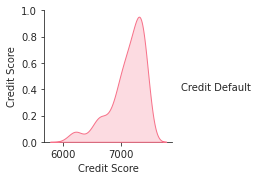

In [14]:
sns.set_style("ticks")
sns.pairplot(data.loc[data['Credit Score'] > 850, ['Credit Score', 'Credit Default']],
             hue = "Credit Default",
             diag_kind = "kde",
             kind = "scatter",
             palette = "husl")
plt.show()

In [15]:
data.loc[data['Current Loan Amount'] == 99999999].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 0 to 7497
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                870 non-null    object 
 1   Annual Income                 870 non-null    float64
 2   Years in current job          829 non-null    object 
 3   Tax Liens                     870 non-null    float64
 4   Number of Open Accounts       870 non-null    float64
 5   Years of Credit History       870 non-null    float64
 6   Maximum Open Credit           870 non-null    float64
 7   Number of Credit Problems     870 non-null    float64
 8   Months since last delinquent  870 non-null    float64
 9   Bankruptcies                  870 non-null    float64
 10  Purpose                       870 non-null    object 
 11  Term                          870 non-null    object 
 12  Current Loan Amount           870 non-null    float64
 13  Curr

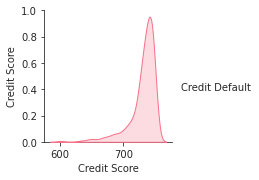

In [16]:
sns.set_style("ticks")
sns.pairplot(data.loc[data['Current Loan Amount'] == 99999999, ['Credit Score', 'Credit Default']],
             hue = "Credit Default",
             diag_kind = "kde",
             kind = "scatter",
             palette = "husl")
plt.show()

In [17]:
data['Credit Score'].mean()

1151.0874978966851

In [18]:
data.loc[data['Credit Score'].isnull(), 'Credit Score'] = 850

In [19]:
data.loc[data['Annual Income'].isnull(), 'Annual Income'] = data['Annual Income'].mean()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [21]:
data.to_csv(datadir + "pds_project_cor.csv", sep=";", index=False)

In [22]:
data.shape

(7500, 18)

## Реализуем Pipeline

### Сочетания характеристик и математические преобразования

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop(["Credit Default", "Id"], axis=1), 
                                                      data["Credit Default"], 
                                                      test_size=0.2, random_state=42)

#save train
X_train.to_csv(datadir + "X_train.csv", index=None)
y_train.to_csv(datadir + "y_train.csv", index=None)

#save valid
X_valid.to_csv(datadir + "X_valid.csv", index=None)
y_valid.to_csv(datadir + "y_valid.csv", index=None)

In [24]:
cat_list

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [25]:
feat_eng_columns = ["Maximum Open Credit", "Annual Income", "Current Loan Amount", 
                    "Current Credit Balance", "Monthly Debt", "Credit Score"]

In [26]:
other_columns = list(set(data.columns) - set(cat_list) - set(feat_eng_columns) - set(['Id', 'Credit Default']))
other_columns

['Months since last delinquent',
 'Number of Open Accounts',
 'Bankruptcies',
 'Number of Credit Problems',
 'Tax Liens',
 'Years of Credit History']

In [27]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.key] = X[self.key].fillna(0)
        return X[self.key]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.key] = X[self.key].fillna(0)
        return X[[self.key]]
    
class CatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        if self.key == "Years in current job":        
            map_Jb = {
                '< 1 year': 0.5,
                '1 year': 1,
                '2 years': 2,
                '3 years': 3,
                '4 years': 4,
                '5 years': 5,
                '6 years': 6,
                '7 years': 7,
                '8 years': 8,
                '9 years': 9,
                '10+ years': 10
            }
            data = data.map(map_Jb)
        elif self.key == "Home Ownership":
            map_HO = {
                'Have Mortgage': 2,
                'Home Mortgage': 2,
                'Own Home': 3,
                'Rent': 1
            }
            data = data.map(map_HO)
        elif self.key == "Term":
            map_T = {
                'Short Term': 0,
                'Long Term': 1
            }
            data = data.map(map_T)
            data = data.astype(np.int64)
        elif self.key == "Purpose":
            map_P = {
                'business loan': 1,
                'buy a car': 2,
                'buy house': 3,
                'debt consolidation': 4,
                'educational expenses': 5,
                'home improvements': 6,
                'major purchase': 7,
                'medical bills': 8,
                'moving': 9,
                'other': 10,
                'renewable energy': 11,
                'small business': 12,
                'take a trip': 13,
                'vacation': 14,
                'wedding': 15
            }
            data = data.map(map_P)  
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data[data.isnull()] = 0
        return pd.DataFrame(data)
    
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
    
    def fit(self, X, y=None):
#         print(f"fit: key: {self.key} columns: {X.columns}")
        self.columns.clear()
        return self
    
    def transform(self, X):
#         print(f"transform: key: {self.key} columns: {X.columns}")
        self.columns.clear()
        data = X.copy()
        data[self.key] = data[self.key].fillna(0)
        data[self.key + '_log'] = np.log(data[self.key] + 1.1)
        self.columns.append(self.key + '_log')

        for i2, col2 in enumerate(feat_eng_columns):
#             print(col2)
            data[col2] = data[col2].fillna(0)
#             X['%s_%s_1' % (self.key, col2)] = X[self.key] - X[col2]
#             X['%s_%s_2' % (self.key, col2)] = X[self.key] + X[col2]
#             X['%s_%s_3' % (self.key, col2)] = X[self.key] / (X[col2] + 0.1)
            data['%s_%s_4' % (self.key, col2)] = data[self.key] * data[col2]
            self.columns.append('%s_%s_4' % (self.key, col2))

#             X['%s_%s_11' % (self.key, col2)] = X[self.key] - np.log(X[col2] + 1)
#             X['%s_%s_22' % (self.key, col2)] = X[self.key] + np.log(X[col2] + 1)
#             X['%s_%s_33' % (self.key, col2)] = X[self.key] / (np.log(X[col2] + 1) + 0.1)
            data['%s_%s_44' % (self.key, col2)] = data[self.key] * np.log(data[col2] + 1)
            self.columns.append('%s_%s_44' % (self.key, col2))
            
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        for col in data.columns.to_list():
            data.loc[data[col].isnull(), col] = 0
        return data[self.columns]

In [28]:
feat_eng_columns

['Maximum Open Credit',
 'Annual Income',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [29]:
final_transformers = list()

for feat_eng_col in feat_eng_columns:
    feat_eng_transformer = Pipeline([('feat_eng', FeatureCreator(key=feat_eng_col))])
    final_transformers.append((feat_eng_col, feat_eng_transformer))

for cat_col in cat_list:
    cat_transformer = Pipeline([('selector', ColumnSelector(key=cat_col)),
                                ('cat_enc', CatEncoder(key=cat_col))
                               ])
    final_transformers.append((cat_col, cat_transformer))
    
for other_col in other_columns:
    other_transformer = Pipeline([
                ('selector', NumberSelector(key=other_col))
            ])
    final_transformers.append((other_col, other_transformer))

In [30]:
total_columns_list = []
total_columns_list.extend(feat_eng_columns)
total_columns_list.extend(cat_list)
total_columns_list.extend(other_columns)
total_columns_list

['Maximum Open Credit',
 'Annual Income',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership',
 'Years in current job',
 'Purpose',
 'Term',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Bankruptcies',
 'Number of Credit Problems',
 'Tax Liens',
 'Years of Credit History']

In [31]:
X_train[[*total_columns_list]].head(2)

,Maximum Open Credit,Annual Income,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership,Years in current job,Purpose,Term,Months since last delinquent,Number of Open Accounts,Bankruptcies,Number of Credit Problems,Tax Liens,Years of Credit History
4664,481580.0,2820569.0,405416.0,173432.0,27030.0,749.0,Rent,< 1 year,debt consolidation,Short Term,77.0,10.0,0.0,0.0,0.0,20.3
4411,49126.0,441769.0,99999999.0,1824.0,9535.0,733.0,Rent,< 1 year,debt consolidation,Short Term,14.0,5.0,0.0,0.0,0.0,12.6


In [32]:
X_train[[*total_columns_list]].head(2).to_dict('dict')

{'Maximum Open Credit': {4664: 481580.0, 4411: 49126.0},
 'Annual Income': {4664: 2820569.0, 4411: 441769.0},
 'Current Loan Amount': {4664: 405416.0, 4411: 99999999.0},
 'Current Credit Balance': {4664: 173432.0, 4411: 1824.0},
 'Monthly Debt': {4664: 27030.0, 4411: 9535.0},
 'Credit Score': {4664: 749.0, 4411: 733.0},
 'Home Ownership': {4664: 'Rent', 4411: 'Rent'},
 'Years in current job': {4664: '< 1 year', 4411: '< 1 year'},
 'Purpose': {4664: 'debt consolidation', 4411: 'debt consolidation'},
 'Term': {4664: 'Short Term', 4411: 'Short Term'},
 'Months since last delinquent': {4664: 77.0, 4411: 14.0},
 'Number of Open Accounts': {4664: 10.0, 4411: 5.0},
 'Bankruptcies': {4664: 0.0, 4411: 0.0},
 'Number of Credit Problems': {4664: 0.0, 4411: 0.0},
 'Tax Liens': {4664: 0.0, 4411: 0.0},
 'Years of Credit History': {4664: 20.3, 4411: 12.6}}

In [33]:
dict_for_api = X_train[[*total_columns_list]].head(3).to_dict('list')
dict_for_api

{'Maximum Open Credit': [481580.0, 49126.0, 562320.0],
 'Annual Income': [2820569.0, 441769.0, 1065178.0],
 'Current Loan Amount': [405416.0, 99999999.0, 224246.0],
 'Current Credit Balance': [173432.0, 1824.0, 197657.0],
 'Monthly Debt': [27030.0, 9535.0, 14557.0],
 'Credit Score': [749.0, 733.0, 738.0],
 'Home Ownership': ['Rent', 'Rent', 'Rent'],
 'Years in current job': ['< 1 year', '< 1 year', '8 years'],
 'Purpose': ['debt consolidation', 'debt consolidation', 'debt consolidation'],
 'Term': ['Short Term', 'Short Term', 'Short Term'],
 'Months since last delinquent': [77.0, 14.0, 41.98792270531401],
 'Number of Open Accounts': [10.0, 5.0, 12.0],
 'Bankruptcies': [0.0, 0.0, 1.0],
 'Number of Credit Problems': [0.0, 0.0, 1.0],
 'Tax Liens': [0.0, 0.0, 0.0],
 'Years of Credit History': [20.3, 12.6, 24.4]}

In [34]:
dict_for_api = X_train[[*total_columns_list]].head(3).T.to_dict('dict').values()
for i in dict_for_api:
    print(type(i))

<class 'dict'>
<class 'dict'>
<class 'dict'>


In [35]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [36]:
feature_processing.steps

[('feats',
  FeatureUnion(transformer_list=[('Maximum Open Credit',
                                  Pipeline(steps=[('feat_eng',
                                                   FeatureCreator(key='Maximum '
                                                                      'Open '
                                                                      'Credit'))])),
                                 ('Annual Income',
                                  Pipeline(steps=[('feat_eng',
                                                   FeatureCreator(key='Annual '
                                                                      'Income'))])),
                                 ('Current Loan Amount',
                                  Pipeline(steps=[('feat_eng',
                                                   FeatureCreator(key='Current '
                                                                      'Loan '
                                                                   

In [37]:
# data_pr = feature_processing.fit_transform(data.drop(["Credit Default", "Id"], axis=1))
# np.shape(data_pr)

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([('features',feats),
                     ('gbc', GradientBoostingClassifier(random_state=42))
                    ])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Maximum Open Credit',
                                                 Pipeline(steps=[('feat_eng',
                                                                  FeatureCreator(key='Maximum '
                                                                                     'Open '
                                                                                     'Credit'))])),
                                                ('Annual Income',
                                                 Pipeline(steps=[('feat_eng',
                                                                  FeatureCreator(key='Annual '
                                                                                     'Income'))])),
                                                ('Current Loan Amount',
                                                 Pipeline(steps=[('feat_eng',
                                           

In [39]:
pipeline_xgbc = Pipeline([
    ('features',feats),
    ('xgbc', XGBClassifier(objective="binary:logistic",
                           nthread=2, 
                           max_depth=9, # 5
                           n_estimators=600, # 100
                           subsample=0.5, 
                           learning_rate=0.3, 
                           seed=1000, 
                           random_state=42,
                           eval_metric='auc'))
])

pipeline_xgbc.fit(X_train, y_train)

/home/vitaly/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Maximum Open Credit',
                                                 Pipeline(steps=[('feat_eng',
                                                                  FeatureCreator(key='Maximum '
                                                                                     'Open '
                                                                                     'Credit'))])),
                                                ('Annual Income',
                                                 Pipeline(steps=[('feat_eng',
                                                                  FeatureCreator(key='Annual '
                                                                                     'Income'))])),
                                                ('Current Loan Amount',
                                                 Pipeline(steps=[('feat_eng',
                                           

In [40]:
cl_met = ['Best Threshold', 'F-Score', 'Precision', 
          'Recall', 'roc_auc_s', 'log_loss_s', 'TPR', 'FPR', 'TNR', "TN", "FN", "TP", "FP"]

res_tab = pd.DataFrame(columns=cl_met)

In [41]:
preds = pipeline.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
r_auc = roc_auc_score(y_true=y_valid, y_score=preds)
l_los = log_loss(y_true=y_valid, y_pred=preds)

print("roc auc score: {}".format(r_auc))
print("log loss score: {}".format(l_los))

cnf_matrix = confusion_matrix(y_valid, preds>thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)

res_tab.loc['GradientBoostingClassifier', :] = [thresholds[ix], 
                                                fscore[ix], 
                                                precision[ix], 
                                                recall[ix], 
                                                r_auc, l_los, 
                                                TPR, FPR, TNR,
                                                TN, FN, TP, FP]

Best Threshold=0.243405, F-Score=0.563, Precision=0.451, Recall=0.748
roc auc score: 0.7668863579426105
log loss score: 0.4754435136592738


In [42]:
preds = pipeline_xgbc.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
r_auc = roc_auc_score(y_true=y_valid, y_score=preds)
l_los = log_loss(y_true=y_valid, y_pred=preds)

print("roc auc score: {}".format(r_auc))
print("log loss score: {}".format(l_los))

cnf_matrix = confusion_matrix(y_valid, preds>thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)

res_tab.loc['XGBClassifier', :] = [thresholds[ix], 
                                   fscore[ix], 
                                   precision[ix], 
                                   recall[ix], 
                                   r_auc, l_los, 
                                   TPR, FPR, TNR,
                                   TN, FN, TP, FP]

Best Threshold=0.014353, F-Score=0.538, Precision=0.406, Recall=0.796
roc auc score: 0.7394816913230511
log loss score: nan


/home/vitaly/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2279: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/vitaly/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2279: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [43]:
res_tab.sort_values('roc_auc_s', ascending=False)

,Best Threshold,F-Score,Precision,Recall,roc_auc_s,log_loss_s,TPR,FPR,TNR,TN,FN,TP,FP
GradientBoostingClassifier,0.243405,0.56266,0.45082,0.748299,0.766886,0.475444,0.746032,0.379603,0.620397,657,112,329,402
XGBClassifier,0.014353,0.537519,0.40578,0.795918,0.739482,NaN,0.793651,0.485364,0.514636,545,91,350,514


In [44]:
with open(modelsdir + "model_cr_gbc.dill", "wb") as f:
    dill.dump(pipeline, f)

In [45]:
# with open(modelsdir + "model_cr_xgbc.dill", "wb") as f:
#     dill.dump(pipeline_xgbc, f)

In [46]:
with open(modelsdir + "model_cr_gbc.dill", 'rb') as f:
    model_l = dill.load(f)
print(model_l)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Maximum Open Credit',
                                                 Pipeline(steps=[('feat_eng',
                                                                  FeatureCreator(key='Maximum '
                                                                                     'Open '
                                                                                     'Credit'))])),
                                                ('Annual Income',
                                                 Pipeline(steps=[('feat_eng',
                                                                  FeatureCreator(key='Annual '
                                                                                     'Income'))])),
                                                ('Current Loan Amount',
                                                 Pipeline(steps=[('feat_eng',
                                           

In [47]:
preds = model_l.predict_proba(X_valid[:3])[:, 1]
preds

<ipython-input-27-cecc559c2a5c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.key] = X[self.key].fillna(0)
<ipython-input-27-cecc559c2a5c>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.key] = X[self.key].fillna(0)


array([0.95769872, 0.11293094, 0.30668614])